In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Unir los datos

In [18]:
# Cargar los datos
df_behavior = pd.read_csv('behavior_summary100N.csv')
# AJUSTA COW_ID: de 0-15 a 1-16
df_behavior['cow_id'] = df_behavior['cow_id'] + 1
df_milk = pd.read_csv('milk_summary.csv')

# Unir los datasets por cow_id y date
df = pd.merge(df_behavior, df_milk, on=['cow_id', 'date'])

# Verificar datos
print(df.head())


   cow_id  date  behavior_0  behavior_1  behavior_2  behavior_3  behavior_4  \
0       1   721    0.008333    0.608333    0.108333    0.241667    0.000000   
1       2   721    0.000000    0.278027    0.044843    0.107623    0.004484   
2       3   721    0.000000    0.652174    0.104348    0.208696    0.008696   
3       4   721    0.000000    0.660920    0.132184    0.166667    0.000000   
4       5   721    0.000000    0.285714    0.291667    0.148810    0.000000   

   behavior_5  behavior_6  milk_weight  
0    0.033333    0.000000       34.927  
1    0.013453    0.551570       43.636  
2    0.000000    0.026087       45.813  
3    0.017241    0.022989       37.104  
4    0.023810    0.250000       53.070  


In [ ]:
# OPCIONAAAAL
df.to_csv("togetheerN.csv", index=False)

# Solo comportamientos

In [ ]:
# Datos para entrenamiento

In [19]:
# X = comportamientos (features), y = producción de leche (target)
X = df[['behavior_0', 'behavior_1', 'behavior_2', 'behavior_3', 
              'behavior_4', 'behavior_5', 'behavior_6']]
y = df['milk_weight']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Entrenamiento Random Forest

In [20]:
# Modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Squared Error (MSE): 33.66
R^2 Score: 0.16


/tmp/ipykernel_1839958/1358067603.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


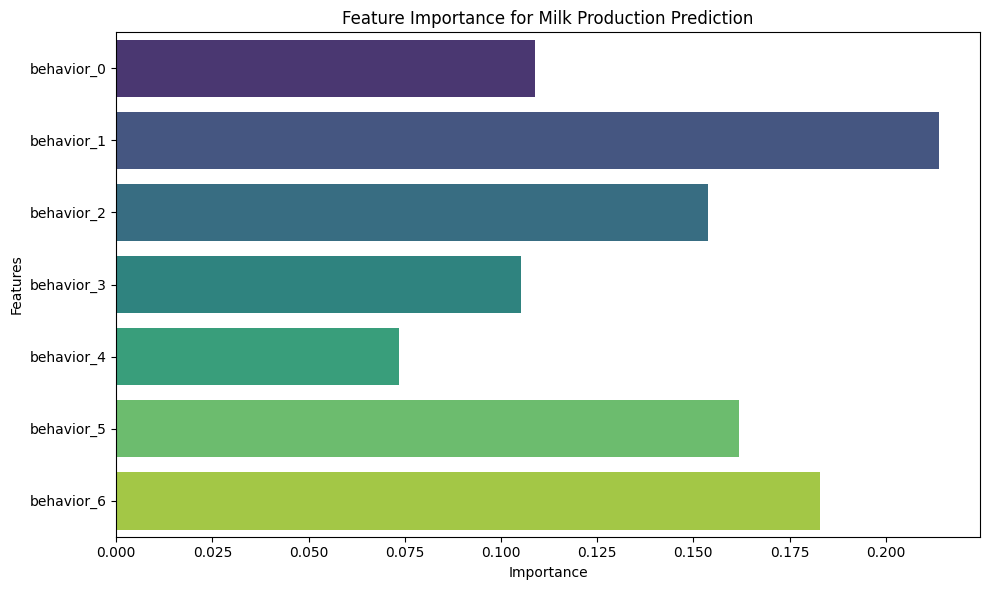

In [21]:
# --- 1. Feature Importance Plot ---
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance for Milk Production Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

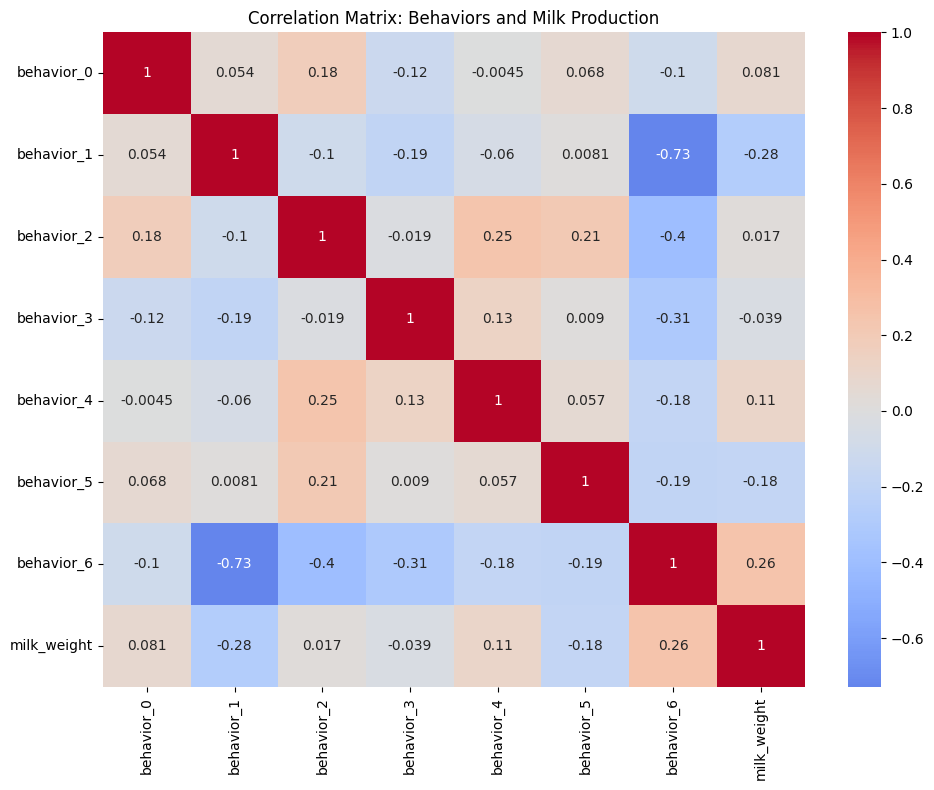

In [22]:
# --- 2. Correlation Matrix ---
df_corr = df[X.columns.tolist() + ['milk_weight']].copy()
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Behaviors and Milk Production")
plt.tight_layout()
plt.show()


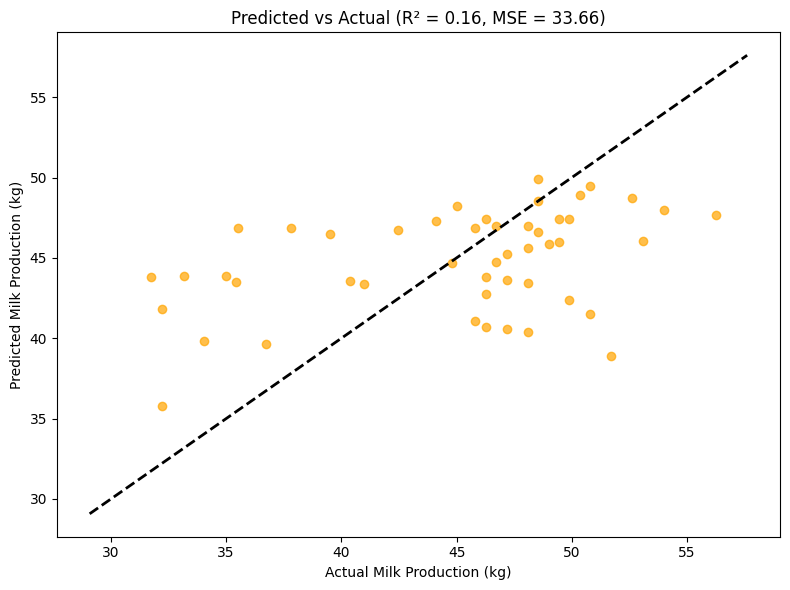

In [23]:
# --- 3. Predictions vs Actual Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Milk Production (kg)')
plt.ylabel('Predicted Milk Production (kg)')
plt.title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred):.2f}, MSE = {mean_squared_error(y_test, y_pred):.2f})')
plt.tight_layout()
plt.show()

# Comportamientos y anterior produccion de leche

Para analizar la relación entre el comportamiento de las vacas y su producción diaria de leche, inicialmente entrenamos un modelo de Random Forest utilizando exclusivamente los conteos diarios de siete comportamientos detectados por visión artificial. Sin embargo, este enfoque mostró baja capacidad predictiva (R² ≈ 0.06), lo que indicó que las actividades aisladas del día actual no explicaban suficientemente la variabilidad en la producción. Por ello, incorporamos una nueva variable: la producción de leche del día anterior (milk_yesterday). Esta decisión se basó en la naturaleza temporal del proceso biológico de producción lechera, donde los valores pasados suelen tener alta inercia. El nuevo modelo mejoró sustancialmente el rendimiento predictivo (R² ≈ 0.72), demostrando que incluir información histórica fortalece significativamente la capacidad del modelo para predecir la producción de leche.

In [24]:
# Ordenamos por cow_id y fecha
df_sorted = df.sort_values(by=['cow_id', 'date'])

# Creamos milk_yesterday
df_sorted['milk_yesterday'] = df_sorted.groupby('cow_id')['milk_weight'].shift(1)

# Eliminamos filas donde falte milk_yesterday
df_model = df_sorted.dropna(subset=['milk_yesterday'])

# Redefinir X e y
X = df_model[['behavior_0', 'behavior_1', 'behavior_2', 'behavior_3', 
              'behavior_4', 'behavior_5', 'behavior_6', 'milk_yesterday']]
y = df_model['milk_weight']


In [25]:
# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 6.965976754908169
R²: 0.7825323544982347


/tmp/ipykernel_1839958/1933790830.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


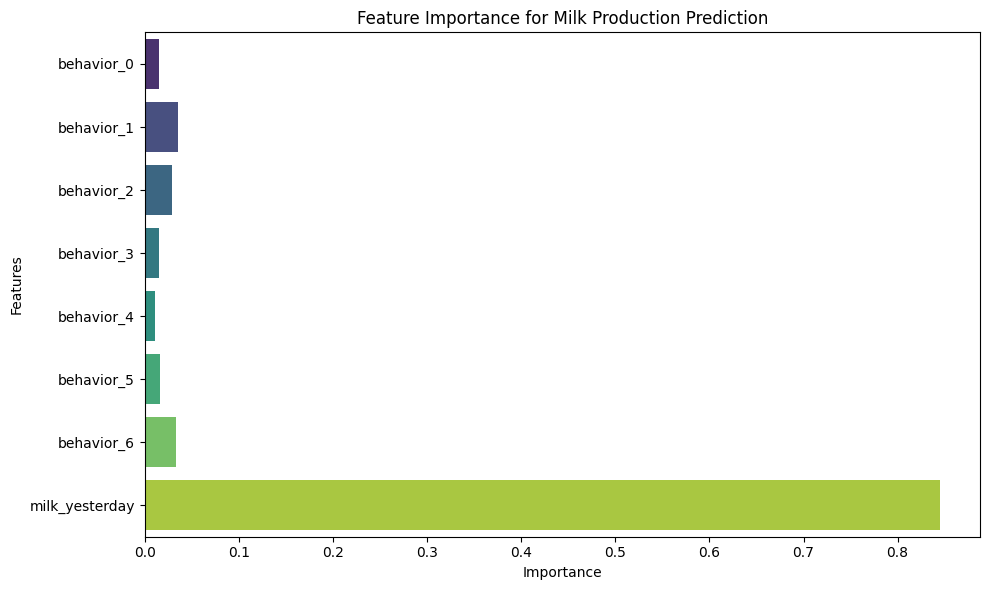

In [26]:
# --- 1. Feature Importance Plot ---
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance for Milk Production Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


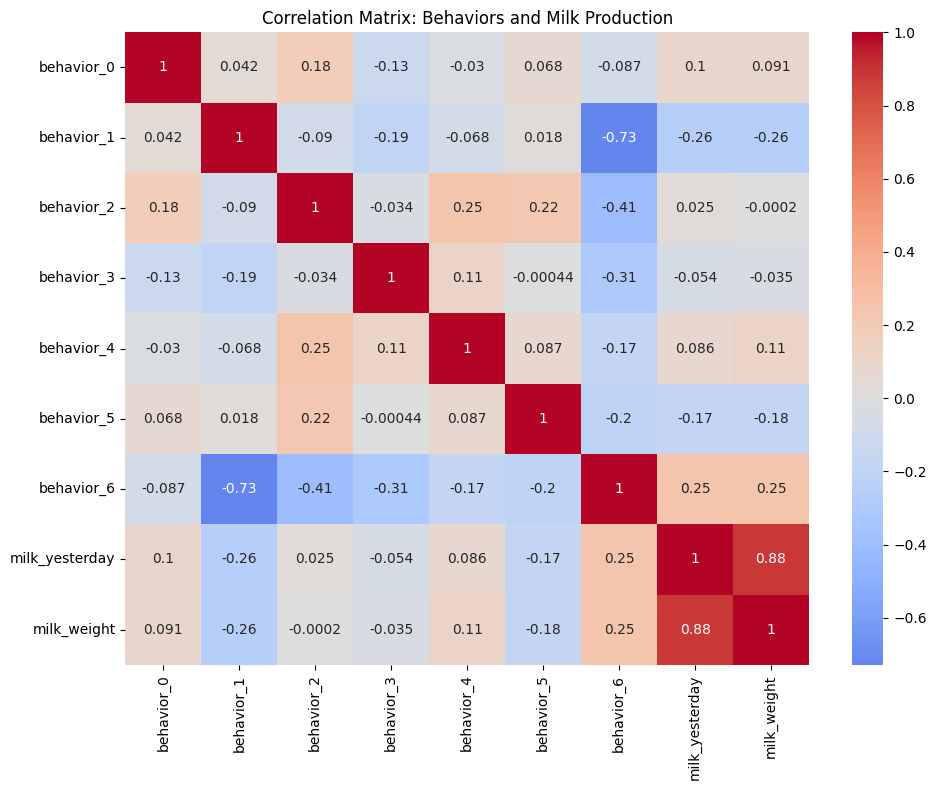

In [27]:
# --- 2. Correlation Matrix ---
df_corr = df_model[X.columns.tolist() + ['milk_weight']].copy()
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Behaviors and Milk Production")
plt.tight_layout()
plt.show()

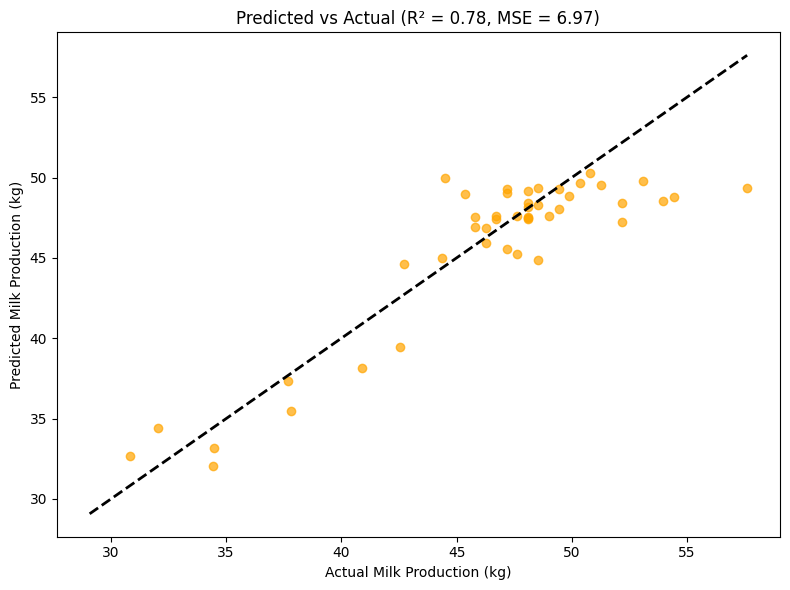

In [28]:
# --- 3. Predictions vs Actual Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Milk Production (kg)')
plt.ylabel('Predicted Milk Production (kg)')
plt.title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred):.2f}, MSE = {mean_squared_error(y_test, y_pred):.2f})')
plt.tight_layout()
plt.show()

# CORELACIONARLOS CON MAS DATOS CLIMATICOS, PRODUCCION DE LECHE ANTERIOR Y BEHAVIORS 

In [29]:

# Cargar los archivos
df_behavior = pd.read_csv("behavior_summary100N.csv")
df_behavior['cow_id'] = df_behavior['cow_id'] + 1
df_milk = pd.read_csv("milk_summary.csv")
df_weather = pd.read_csv("weather_summary.csv")

# Asegurar que todas las fechas sean strings
df_behavior['date'] = df_behavior['date'].astype(str)
df_milk['date'] = df_milk['date'].astype(str)
df_weather['date'] = df_weather['date'].astype(str)

# Unir comportamiento y leche por cow_id y date
df = pd.merge(df_behavior, df_milk, on=['cow_id', 'date'])

# Unir clima solo por date (sin cow_id)
df = pd.merge(df, df_weather, on='date')

# Mostrar resultado
print(df.head())


   cow_id date  behavior_0  behavior_1  behavior_2  behavior_3  behavior_4  \
0       1  721    0.008333    0.608333    0.108333    0.241667    0.000000   
1       2  721    0.000000    0.278027    0.044843    0.107623    0.004484   
2       3  721    0.000000    0.652174    0.104348    0.208696    0.008696   
3       4  721    0.000000    0.660920    0.132184    0.166667    0.000000   
4       5  721    0.000000    0.285714    0.291667    0.148810    0.000000   

   behavior_5  behavior_6  milk_weight  temperature_F  humidity_per        THI  
0    0.033333    0.000000       34.927      25.708128      50.52959  72.973308  
1    0.013453    0.551570       43.636      25.708128      50.52959  72.973308  
2    0.000000    0.026087       45.813      25.708128      50.52959  72.973308  
3    0.017241    0.022989       37.104      25.708128      50.52959  72.973308  
4    0.023810    0.250000       53.070      25.708128      50.52959  72.973308  


In [30]:

# Ordenar por vaca y fecha (MMDD) para crear milk_yesterday
df = df.sort_values(by=['cow_id', 'date'])
df['milk_yesterday'] = df.groupby('cow_id')['milk_weight'].shift(1)

# Eliminar filas con NaN en milk_yesterday
df_model = df.dropna(subset=['milk_yesterday'])

# Seleccionar columnas predictoras (todas menos cow_id, date y milk_weight)
feature_cols = [col for col in df_model.columns if col not in ['cow_id', 'date', 'milk_weight']]
X = df_model[feature_cols]
y = df_model['milk_weight']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 6.648376038992946
R²: 0.7924473861341204


/tmp/ipykernel_1839958/1358067603.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


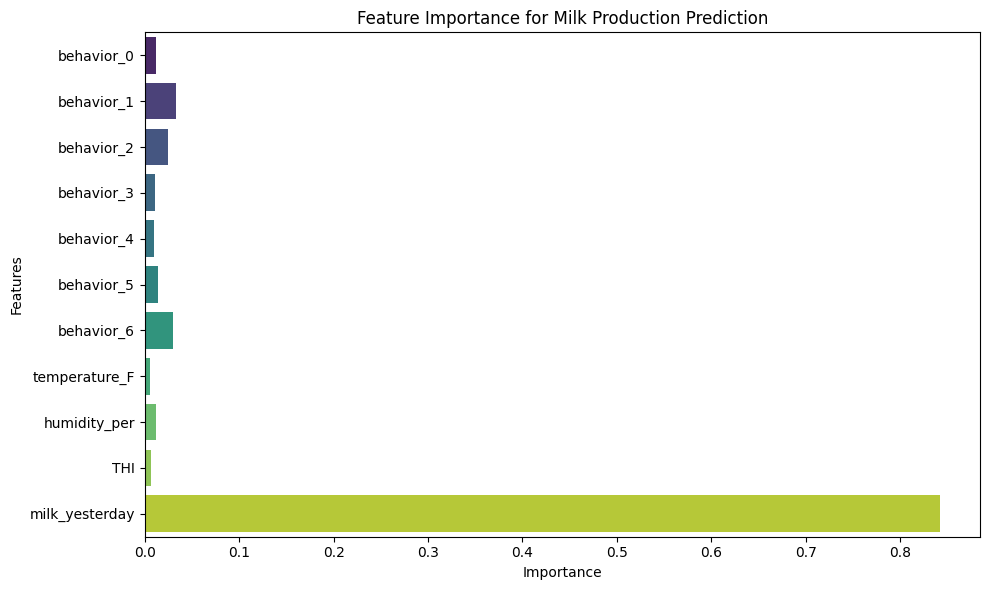

In [31]:
# --- 1. Feature Importance Plot ---
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance for Milk Production Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

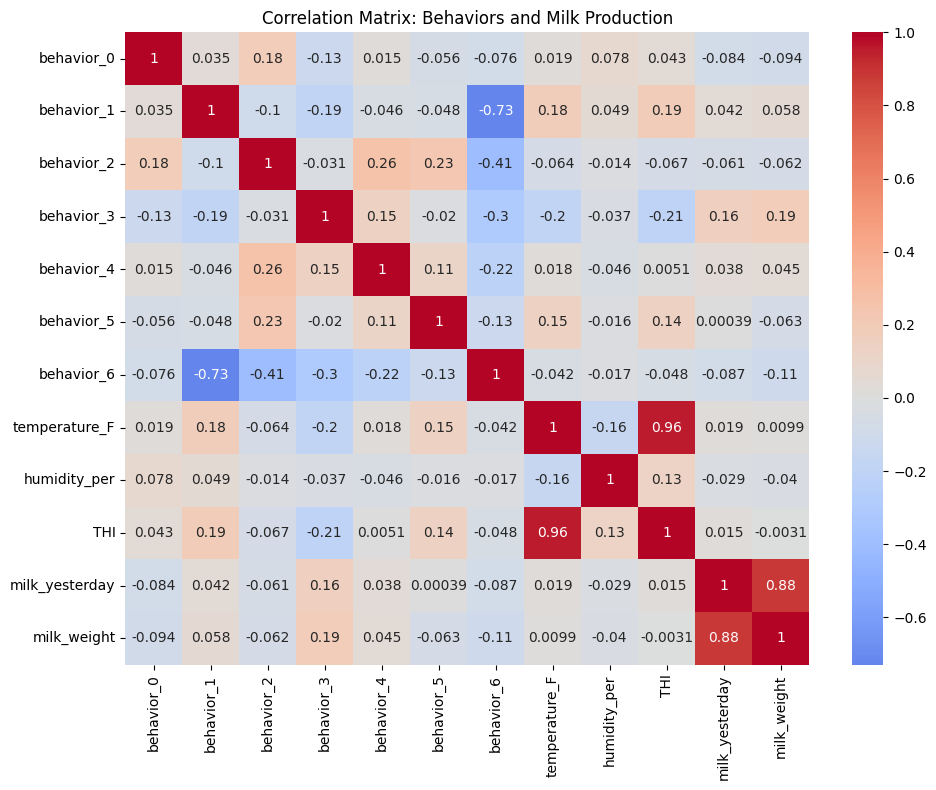

In [16]:
# --- 2. Correlation Matrix ---
df_corr = df[X.columns.tolist() + ['milk_weight']].copy()
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Behaviors and Milk Production")
plt.tight_layout()
plt.show()

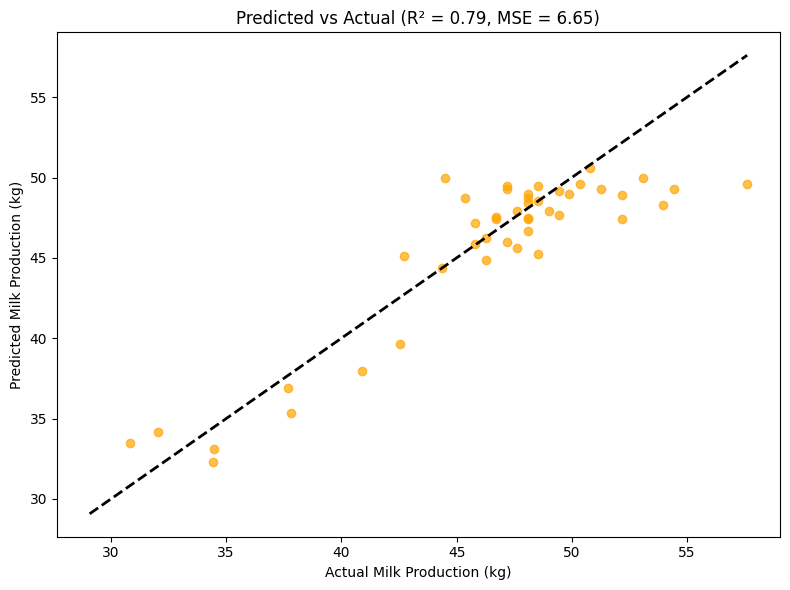

In [32]:
# --- 3. Predictions vs Actual Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Milk Production (kg)')
plt.ylabel('Predicted Milk Production (kg)')
plt.title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred):.2f}, MSE = {mean_squared_error(y_test, y_pred):.2f})')
plt.tight_layout()
plt.show()